# LISA Parameter Selection

Based on the calculation of Moran's *I* across different parameters values (*k* for KNN, *distance* for Distance Band), we are able to identify the most ideal parameters to use. The maximum *I* values indicate where spatial autocorrelation is the strongest, therefore the parameter values at these maximum *I* values indicates the most suitable values to use.

The results (shown below) indicate that the most suitable parameters are `k = 5` and `distance = 5000` (meters).

Given the resulting metrics, such as Global Moran's *I* across different neighborhood parameters and the number of islands that resulted from the various weight construction methods, polygonal data will use Queen's contiguity and network data will use both Fuzzy contiguity and KNN for constucting the spatial weights.

Luke Zaruba, Bryan Runck

In [1]:
# Imports
import warnings

warnings.filterwarnings("ignore")

import geopandas as gpd
import pandas as pd
from esda import Moran
from pysal.lib import weights
from splot.libpysal import plot_spatial_weights

## Data

In [2]:
# Importing from GeoJSON
incidents_gdf = gpd.read_file("../../data/core/INCIDENTS.geojson")
ctu_gdf = gpd.read_file("../../data/core/CTU.geojson")
aadt_gdf = gpd.read_file("../../data/core/Annual_Average_Daily_Traffic_Segments_in_Minnesota.shp")

# Coordinate System Transform
incidents_gdf = incidents_gdf.to_crs(aadt_gdf.crs)

# Drop Unneeded Columns
aadt_gdf = aadt_gdf.drop([c for c in aadt_gdf.columns if c not in ["CURRENT_VO", "geometry"]], axis=1)

# Remove invalid features
aadt_gdf = aadt_gdf.loc[aadt_gdf["geometry"].is_valid]

aadt_gdf.head()

CURRENT_VO                                           geometry
0       629.0  LINESTRING (478576.969 5118194.000, 478975.563...
1      1712.0  LINESTRING (478576.969 5118194.000, 478583.625...
2      1192.0  LINESTRING (459579.563 5120185.000, 459606.157...
3      2712.0  LINESTRING (442104.938 5132530.499, 442228.657...
4      1109.0  LINESTRING (442104.938 5132530.499, 442193.531...

In [3]:
# Spatial Joining Incidents to Roads
joined_aadt = gpd.sjoin_nearest(incidents_gdf, aadt_gdf)

joined_aadt = joined_aadt.drop_duplicates("icr")

# Aggregating
point_counts_aadt = joined_aadt.groupby("index_right").size().reset_index(name="INCIDENT_COUNT")

In [4]:
# Join Counts Back to Lines
aadt_gdf = aadt_gdf.merge(point_counts_aadt, left_index=True, right_on="index_right", how="left")

# Fill any NaN values (lines with no nearby points) with 0
aadt_gdf["INCIDENT_COUNT"] = aadt_gdf["INCIDENT_COUNT"].fillna(0)

# Drop unnecessary columns
aadt_gdf.drop(columns=["index_right"], inplace=True)

aadt_gdf = aadt_gdf.reset_index(drop=True)

# Calculate the length of each road segment
aadt_gdf["LENGTH"] = aadt_gdf["geometry"].length

# Normalize accident counts
aadt_gdf["INCIDENT_DENSITY"] = aadt_gdf["INCIDENT_COUNT"] / aadt_gdf["LENGTH"]
aadt_gdf["INCIDENT_RATE"] = aadt_gdf["INCIDENT_COUNT"] / aadt_gdf["CURRENT_VO"]
aadt_gdf["INCIDENT_INTENSITY"] = aadt_gdf["INCIDENT_COUNT"] / (aadt_gdf["CURRENT_VO"] / aadt_gdf["LENGTH"])
aadt_gdf["INCIDENT_EXPOSURE"] = aadt_gdf["INCIDENT_COUNT"] / (aadt_gdf["CURRENT_VO"] * aadt_gdf["LENGTH"])

# Get data values
data = aadt_gdf["INCIDENT_COUNT"].values

# Reset Index
aadt_gdf.reset_index(inplace=True)

aadt_gdf.head()

index  CURRENT_VO                                           geometry  \
0      0       629.0  LINESTRING (478576.969 5118194.000, 478975.563...   
1      1      1712.0  LINESTRING (478576.969 5118194.000, 478583.625...   
2      2      1192.0  LINESTRING (459579.563 5120185.000, 459606.157...   
3      3      2712.0  LINESTRING (442104.938 5132530.499, 442228.657...   
4      4      1109.0  LINESTRING (442104.938 5132530.499, 442193.531...   

   INCIDENT_COUNT        LENGTH  INCIDENT_DENSITY  INCIDENT_RATE  \
0             4.0  21544.491854          0.000186       0.006359   
1             0.0   2644.750045          0.000000       0.000000   
2             2.0  11354.308303          0.000176       0.001678   
3             1.0   6587.415813          0.000152       0.000369   
4             7.0  20312.608090          0.000345       0.006312   

   INCIDENT_INTENSITY  INCIDENT_EXPOSURE  
0          137.007897       2.951706e-07  
1            0.000000       0.000000e+00  
2           19.050853       1.477723e-07  
3            2.428988       5.597515e-08  
4          128.213036       3.107426e-07

## Spatial Weight Construction

### Polygon

#### Queen's

In [5]:
# Queen
w_q = weights.Queen.from_dataframe(ctu_gdf)

len(w_q.islands)

0

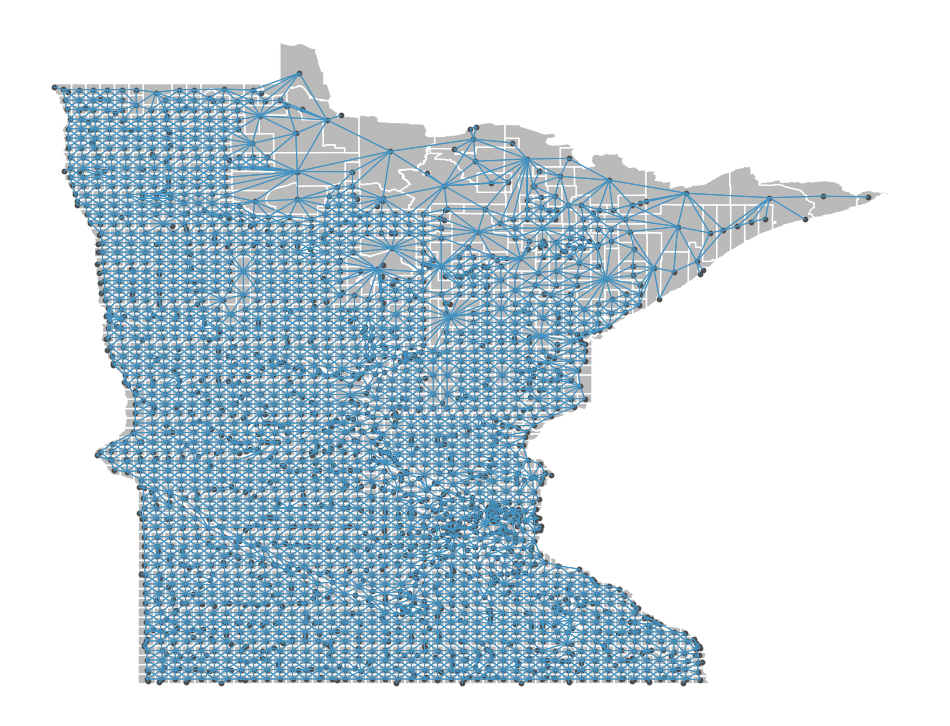

In [6]:
# Plot
plot_spatial_weights(w_q, ctu_gdf, figsize=(12, 12));

### Network

#### Queen

In [7]:
# Queen
w_q = weights.Queen.from_dataframe(aadt_gdf)

len(w_q.islands)

811

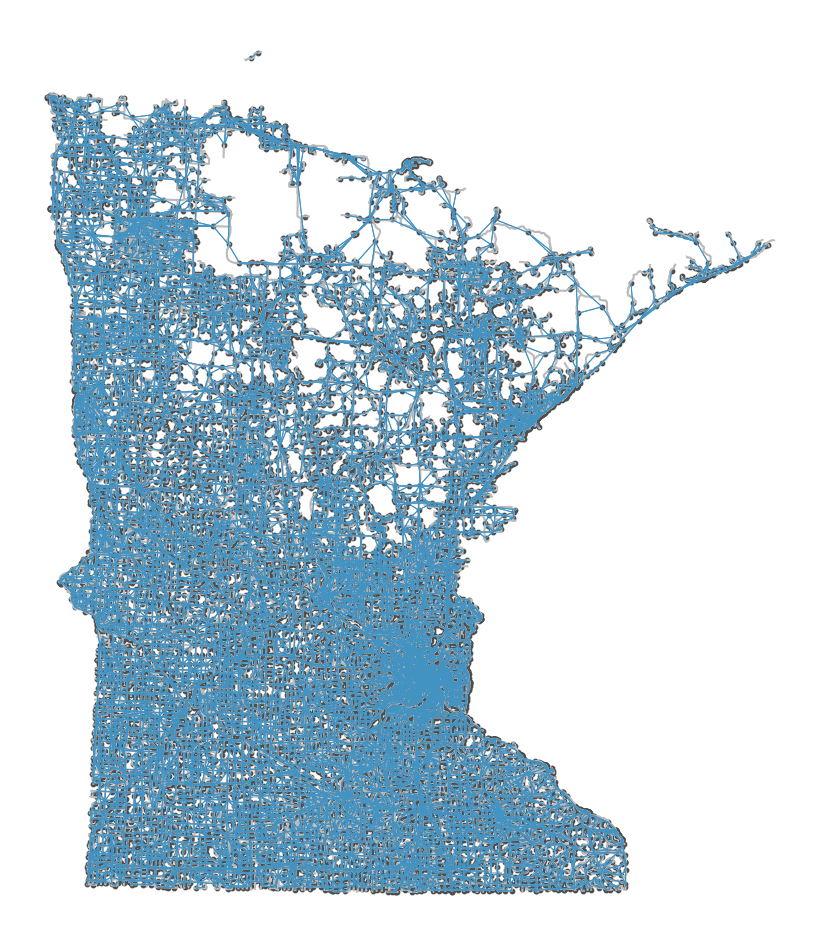

In [8]:
# Plot
plot_spatial_weights(w_q, aadt_gdf, figsize=(12, 12));

#### Fuzzy

In [9]:
# Fuzzy
w_f = weights.fuzzy_contiguity(aadt_gdf)

len(w_f.islands)

599

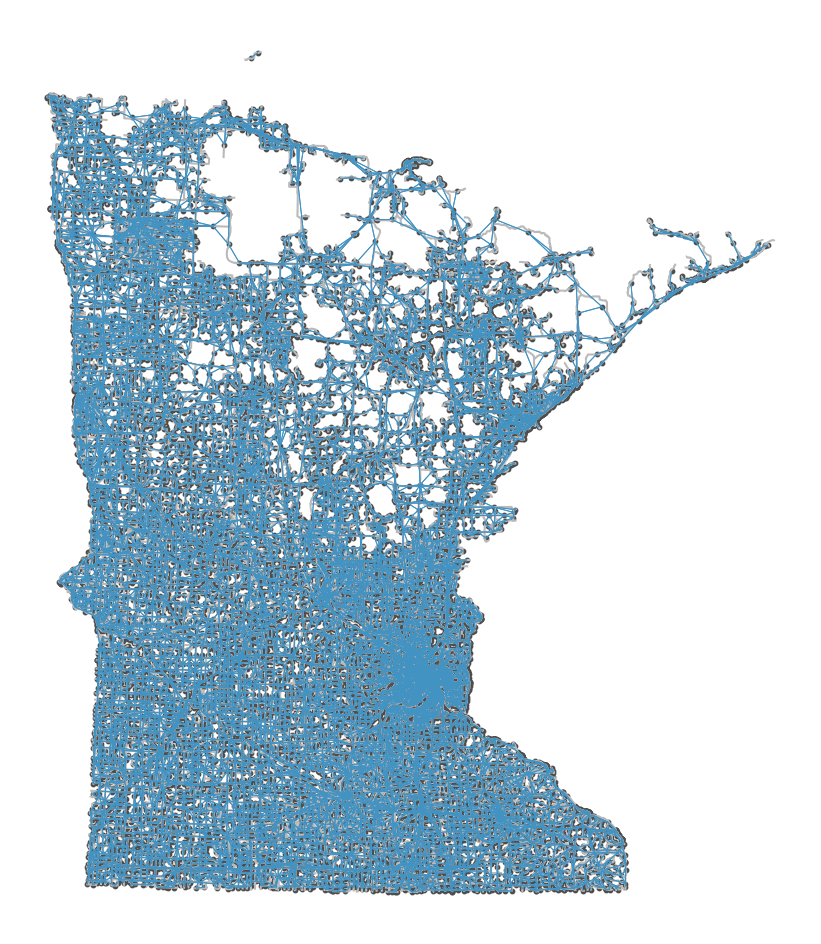

In [10]:
# Plot
plot_spatial_weights(w_f, aadt_gdf, figsize=(12, 12));

#### KNN

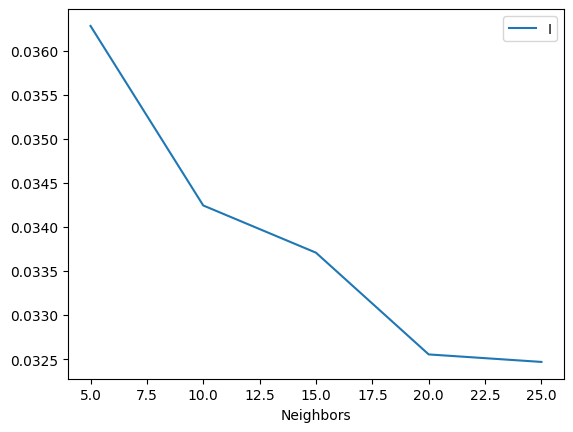

In [11]:
# KNN
neighbors = [5, 10, 15, 20, 25]
knn_moran = []

for val in neighbors:
    w = weights.KNN.from_dataframe(aadt_gdf, k=val)
    m = Moran(data, w)
    
    knn_moran.append(m.I)

knn = pd.DataFrame({"Neighbors": neighbors, "I": knn_moran})

knn.plot.line(x="Neighbors", y="I");

In [12]:
# Islands
w_knn = weights.KNN.from_dataframe(aadt_gdf, k=5)

len(w_knn.islands)

0

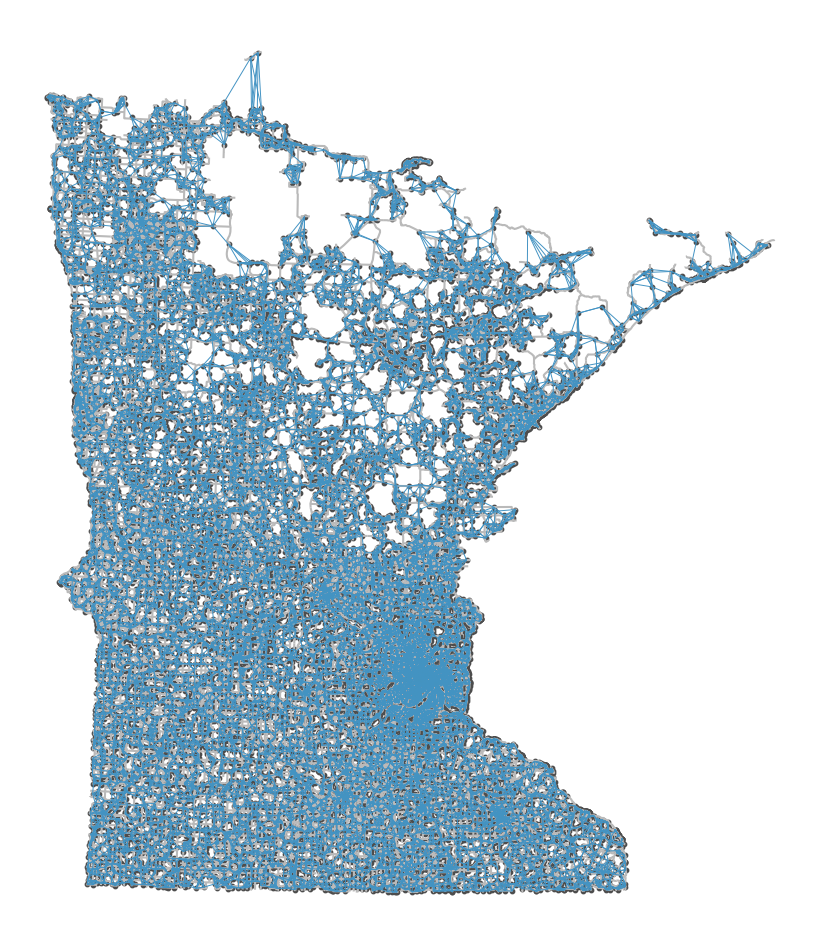

In [13]:
# Plot
plot_spatial_weights(w_knn, aadt_gdf, figsize=(12, 12));

#### Distance Band

('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 1, ' is an island (no neighbors)')
('WARNING: ', 2, ' is an island (no neighbors)')
('WARNING: ', 3, ' is an island (no neighbors)')
('WARNING: ', 4, ' is an island (no neighbors)')
('WARNING: ', 6, ' is an island (no neighbors)')
('WARNING: ', 7, ' is an island (no neighbors)')
('WARNING: ', 8, ' is an island (no neighbors)')
('WARNING: ', 9, ' is an island (no neighbors)')
('WARNING: ', 11, ' is an island (no neighbors)')
('WARNING: ', 15, ' is an island (no neighbors)')
('WARNING: ', 16, ' is an island (no neighbors)')
('WARNING: ', 17, ' is an island (no neighbors)')
('WARNING: ', 18, ' is an island (no neighbors)')
('WARNING: ', 19, ' is an island (no neighbors)')
('WARNING: ', 20, ' is an island (no neighbors)')
('WARNING: ', 22, ' is an island (no neighbors)')
('WARNING: ', 23, ' is an island (no neighbors)')
('WARNING: ', 24, ' is an island (no neighbors)')
('WARNING: ', 25, ' is an island (no neighbors)')
('WARNING

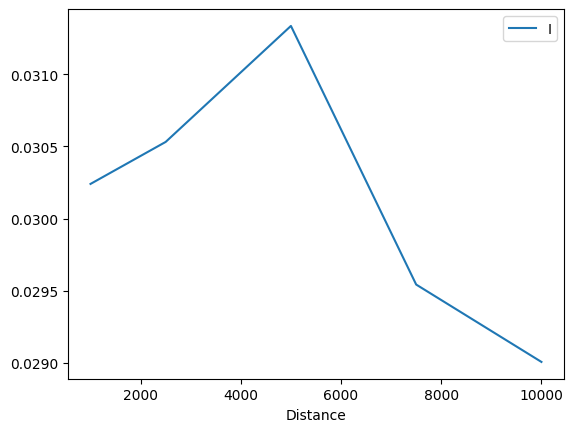

In [14]:
# Distance Band
distances = [1000, 2500, 5000, 7500, 10000]
dist_moran = []

for val in distances:
    w = weights.DistanceBand.from_dataframe(aadt_gdf, val)
    m = Moran(data, w)
    
    dist_moran.append(m.I)

distance = pd.DataFrame({"Distance": distances, "I": dist_moran})

distance.plot.line(x="Distance", y="I");

In [15]:
# Islands
w_db = weights.DistanceBand.from_dataframe(aadt_gdf, 5000)

len(w_db.islands)

172

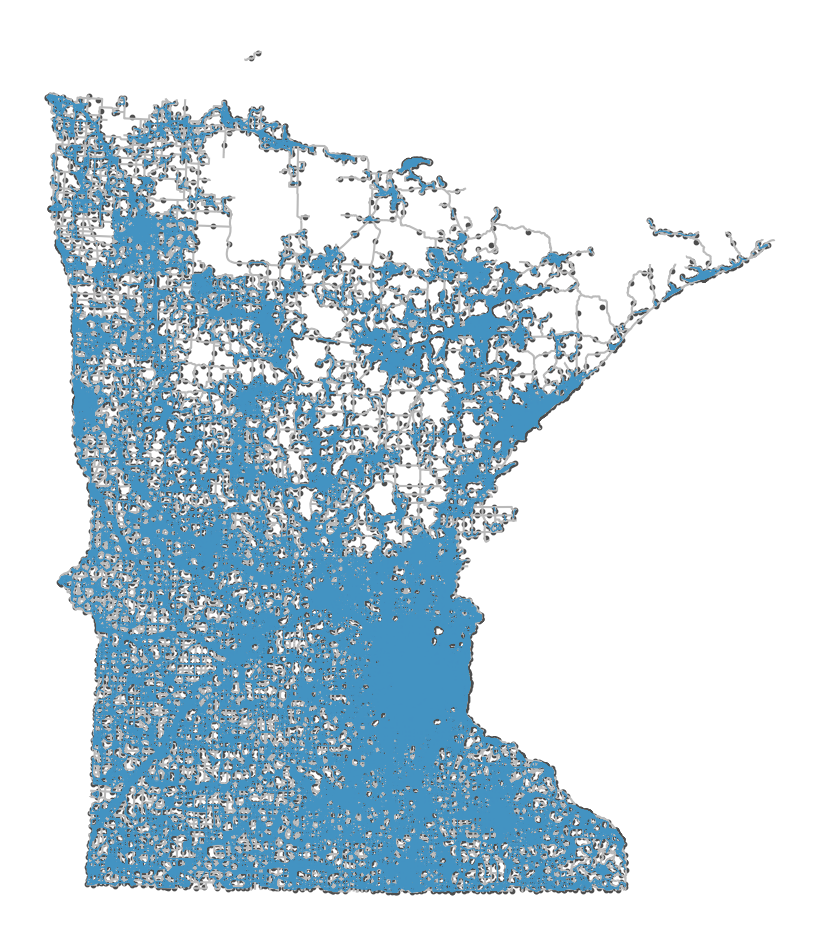

In [16]:
# Plot
plot_spatial_weights(w_db, aadt_gdf, figsize=(12, 12));